# Backcast Modeling CYGNSS Data

fitting facebook's prophet model to timeseries satellite data to predict previous microplastic concentrations by longhurst oceanographic region

## Import Libraries

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pprint import pprint
from datetime import date, timedelta, datetime
import requests
import xarray as xr
import rioxarray
from shapely.geometry import mapping

import earthaccess

### Load Savoca Dataset

In [3]:
# get the number of columns in the csv file
with open('../agg_data_cleaned.csv') as x:
    ncols = len(x.readline().split(','))
    
# load in the data skipping the first empty column
df = pd.read_csv('../agg_data_cleaned.csv',usecols=range(1,ncols))
df

,Scientific name,Common name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,...,Reference,Quantified microplastic,Method type,Marine/estuarine,Equipment used,Capture purpose,Polymer confirmation,Blanks used,Clean lab procedures used,parsed_date
0,Platicephalus indicus,Bartail flathead,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.300000,reef-associated,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
1,Saurida tumbil,Greater lizardfish,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.800000,reef-associated,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
2,Sillago sihama,Silver sillago,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.500000,reef-associated,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
3,Cynoglossus abbreviatus,Three-lined tounge sole,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.900000,demersal,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
4,Galeus melastomus,Blackmouth catshark,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.057120,demersal,...,Alomar and Deudero 2017,Y,2,marine,trawling,bycatch,FTIR,open-air lab control,not described,"(Timestamp('2006-01-01 00:00:00'), Timestamp('..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,Coryphaena hippurus,Common dolphinfish,Perciformes,Coryphaenidae,4.4,20.0,2219.0,0.009013,0.015773,pelagic-neritic,...,Manooch et al. 1983,N,1,marine,hook-and-line,recreational fishing,none,NaN,NaN,"(Timestamp('1980-01-01 00:00:00'), Timestamp('..."
797,Prionace glauca,Blue shark,Carcharhiniformes,Carcharhinidae,4.4,29.0,893.0,0.032475,0.035800,pelagic-oceanic,...,Markaida and Sosa-Nishizaki 2010,N,1,marine,longline,"plastic study, artisanal fishery",none,NaN,NaN,"(Timestamp('1995-01-01 00:00:00'), Timestamp('..."
798,Coryphaena hippurus,Common dolphinfish,Perciformes,Coryphaenidae,4.4,1.0,1.0,1.000000,1.000000,pelagic-oceanic,...,Menezes et al. 2019,N,1,marine,line,incidental,none,NaN,NaN,"(Timestamp('2011-07-01 00:00:00'), Timestamp('..."
799,Thunnus alalunga,Albacore tuna,Perciformes,Scombridae,4.3,1.0,2.0,0.500000,NaN,pelagic-oceanic,...,Sajikumar et al. 2013; from GESAMP 2016,N,1,marine,NaN,NaN,none,NaN,NaN,NaN


### Subset to Quantified MPs

In [4]:
df = df[df['Quantified microplastic'] == 'Y']
df

,Scientific name,Common name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,...,Reference,Quantified microplastic,Method type,Marine/estuarine,Equipment used,Capture purpose,Polymer confirmation,Blanks used,Clean lab procedures used,parsed_date
0,Platicephalus indicus,Bartail flathead,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.30000,reef-associated,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
1,Saurida tumbil,Greater lizardfish,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.80000,reef-associated,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
2,Sillago sihama,Silver sillago,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.50000,reef-associated,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
3,Cynoglossus abbreviatus,Three-lined tounge sole,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.90000,demersal,...,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes,"(Timestamp('2015-01-01 00:00:00'), Timestamp('..."
4,Galeus melastomus,Blackmouth catshark,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.05712,demersal,...,Alomar and Deudero 2017,Y,2,marine,trawling,bycatch,FTIR,open-air lab control,not described,"(Timestamp('2006-01-01 00:00:00'), Timestamp('..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,Malakichthys griseus,NaN,Perciformes,Acropomatidae,3.2,1.0,1.0,1.000000,3.77000,pelagic-oceanic,...,Zhu et al. 2019,Y,3,marine,bottom trawls,plastic study,FTIR,lab blank,yes,"(Timestamp('2017-03-01 00:00:00'), Timestamp('..."
686,Neoscopelus microchir,shortfin neoscopelid,Myctophiformes,Neoscopelidae,3.2,1.0,1.0,1.000000,3.78000,bathypelagic,...,Zhu et al. 2019,Y,3,marine,bottom trawls,plastic study,FTIR,lab blank,yes,"(Timestamp('2017-03-01 00:00:00'), Timestamp('..."
687,Polymetme elongata,NaN,Stomiiformes,Phosichthyidae,3.6,1.0,1.0,1.000000,7.50000,benthopelagic,...,Zhu et al. 2019,Y,3,marine,bottom trawls,plastic study,FTIR,lab blank,yes,"(Timestamp('2017-03-01 00:00:00'), Timestamp('..."
688,Rexea solandri,Silver gemfish,Perciformes,Gempylidae,4.3,3.0,3.0,1.000000,4.40000,benthopelagic,...,Zhu et al. 2019,Y,3,marine,bottom trawls,plastic study,FTIR,lab blank,yes,"(Timestamp('2017-03-01 00:00:00'), Timestamp('..."


### Load Longhurst Region Shapes

In [5]:
longhurst = gpd.read_file('../Savoca/Longhurst_world_v4_2010.shp')

In [6]:
longhurst

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),"MULTIPOLYGON (((-161.184 63.500, -161.500 63.5..."
1,ARCT,Polar - Atlantic Arctic Province,"MULTIPOLYGON (((-21.513 64.644, -21.559 64.641..."
2,SARC,Polar - Atlantic Subarctic Province,"MULTIPOLYGON (((11.265 63.961, 11.095 63.886, ..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),"POLYGON ((-11.500 57.500, -11.500 56.500, -11...."
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.500 43.500, -43.500 42.500, -43...."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-39.500 25.500, -40.500 25.500, -41...."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.347 18.536, -72.369 18.526..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-19.500 -6.500, -20.500 -6.500, -21...."
8,ETRA,Trades - Eastern Tropical Atlantic Province,"POLYGON ((9.500 -12.500, 8.500 -12.500, 7.500 ..."
9,SATL,Trades - South Atlantic Gyral Province (SATG),"POLYGON ((-19.500 -6.500, -18.500 -6.500, -17...."


### Define CYGNSS Coverage wrt Longhurst

In [7]:
# Define bounds
latmax, lonmax, latmin, lonmin = 37, 180, -37, -180

# Assuming 'longhurst' is your GeoDataFrame
# Get the bounds for each polygon (returns minx, miny, maxx, maxy)
longhurst_bounds = longhurst.geometry.bounds

# Filter the provinces that fall within the specified bounds
mask = (
        (longhurst_bounds.minx >= lonmin) &  # minimum longitude
        (longhurst_bounds.maxx <= lonmax) &  # maximum longitude
        (longhurst_bounds.miny >= latmin) &  # minimum latitude
        (longhurst_bounds.maxy <= latmax)    # maximum latitude
       )

# additional mask to include partial regions of zones to be clipped
mask_partial = (
                (longhurst_bounds.minx >= lonmin) |  # minimum longitude
                (longhurst_bounds.maxx <= lonmax) |  # maximum longitude
                (longhurst_bounds.miny >= latmin) |  # minimum latitude
                (longhurst_bounds.maxy <= latmax)    # maximum latitude
               )

# Apply the filter to your original GeoDataFrame
filtered_provinces = longhurst[mask_partial]

### Load Local Copy of CYGNSS Data

In [8]:
try:
    with open('mp_sat_data.pkl', 'rb') as f:
        cygnss_data = pickle.load(f)
except:
    data_folder = "/Volumes/samsung1TB/CYGNSS_L3_MICROPLASTIC_V3.2_3.2-20241028_073551/"
    satellite_files = os.listdir(data_folder)
    satellite_files = [data_folder + file for file in satellite_files if not file.startswith(".")]
    cygnss_data = xr.open_mfdataset(satellite_files)

### Convert CYGNSS Data to Proper Coordinate Reference System

In [9]:
mp_sat_data = cygnss_data

In [10]:
print(f"Latitude range: {mp_sat_data.lat.min().values} to {mp_sat_data.lat.max().values}")
print(f"Longitude range: {mp_sat_data.lon.min().values} to {mp_sat_data.lon.max().values}")

Latitude range: -37.0 to 37.0
Longitude range: -180.0 to 179.75


In [11]:
if mp_sat_data.rio.crs is not None:
    print(f"Dataset CRS: {mp_sat_data.rio.crs}")
else:
    print("Dataset CRS is not set.")

Dataset CRS: EPSG:4326


In [12]:
mp_sat_data = mp_sat_data.rio.write_crs("EPSG:4326", inplace=True)
mp_sat_data = mp_sat_data.assign_coords(lon=(((mp_sat_data.lon + 180) % 360) - 180)).sortby('lon')
mp_sat_data = mp_sat_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

In [13]:
longhurst = longhurst.cx[:, -37.0:37.0]

### Calculate Region Level MP Statistics

Running these takes a while (a really really really long time ~12hrs) so added section to save the results as a pkl file

In [14]:
try:
    aggregated_df = pd.read_pickle('aggregated_df2.pkl')
except:
    aggregated_results = {'mean':[], 'median':[], 'std':[]}
    
    for _, polygon in longhurst.iterrows():
        print('Starting polygon #',_)
        # Mask the dataset by the current polygon
        masked_ds = mp_sat_data.rio.clip([mapping(polygon.geometry)], mp_sat_data.rio.crs, drop=True)

        # Aggregate (e.g., mean concentration within the polygon)
        mean_concentration = masked_ds['mp_concentration'].mean(dim=['lat', 'lon'], skipna=True)
        median_concentration = masked_ds['mp_concentration'].median(dim=['lat', 'lon'], skipna=True)
        std_concentration = masked_ds['mp_concentration'].std(dim=['lat', 'lon'], skipna=True)
        aggregated_results['mean'].append(mean_concentration.values)
        aggregated_results['median'].append(median_concentration.values)
        aggregated_results['std'].append(std_concentration.values)

    # Convert results to a DataFrame for easier viewing or further analysis
    # aggregated_df = pd.DataFrame({
    #     'region': longhurst['ProvCode'],  # Replace with the appropriate column name for regions
    #     'stats': aggregated_results
    # })
    aggregated_df = pd.DataFrame.from_dict(aggregated_results)
    aggregated_df['ProvCode'] = longhurst['ProvCode'].values
    aggregated_df['ProvDescr'] = longhurst['ProvDescr'].values

In [15]:
aggregated_df

,mean,median,std,ProvCode
0,"[13154.5205, 13050.786, 12861.714, 12802.68, 1...","[13026.948, 12940.222, 12672.045, 12627.126, 1...","[486.53815, 493.23563, 556.14716, 547.8448, 52...",GFST
1,"[14359.373, 14266.317, 14168.504, 14053.972, 1...","[14379.951, 14248.299, 14121.833, 13995.798, 1...","[666.4824, 664.47266, 637.2081, 602.5007, 608....",NASW
2,"[13542.371, 13510.258, 13463.988, 13410.905, 1...","[13514.954, 13495.38, 13457.4375, 13415.717, 1...","[416.2826, 407.1931, 409.5267, 403.1756, 404.4...",NATR
3,"[13868.221, 13866.623, 13874.723, 13898.819, 1...","[13646.158, 13645.677, 13681.869, 13725.515, 1...","[832.3508, 813.353, 810.85065, 812.9241, 836.4...",WTRA
4,"[13692.601, 13710.975, 13703.186, 13661.056, 1...","[13635.787, 13656.321, 13638.697, 13605.748, 1...","[595.6204, 597.10266, 591.9763, 565.4013, 541....",ETRA
5,"[12861.415, 12872.765, 12888.363, 12900.2295, ...","[12839.993, 12851.982, 12872.821, 12886.625, 1...","[268.29996, 271.62698, 273.54886, 280.4534, 28...",SATL
6,"[13351.869, 13260.669, 13144.64, 13060.0, 1301...","[13206.308, 13153.692, 13040.445, 12978.766, 1...","[573.0755, 490.6029, 420.4381, 415.62177, 434....",CNRY
7,"[14010.337, 13970.553, 13941.722, 13902.539, 1...","[13885.9375, 13835.084, 13801.53, 13754.1875, ...","[820.6399, 792.44794, 811.71075, 823.5238, 826...",GUIN
8,"[13671.145, 13730.748, 13764.726, 13773.954, 1...","[13570.064, 13630.763, 13701.962, 13691.387, 1...","[936.75806, 953.5369, 963.9417, 985.8951, 1042...",GUIA
9,"[14237.641, 14229.613, 14110.575, 13952.016, 1...","[14122.946, 14167.468, 14099.944, 14020.211, 1...","[781.22687, 806.4925, 773.4135, 749.0714, 701....",NWCS


In [16]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mean      42 non-null     object
 1   median    42 non-null     object
 2   std       42 non-null     object
 3   ProvCode  42 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [17]:
print(f"Latitude range: {mp_sat_data.lat.min().values} to {mp_sat_data.lat.max().values}")
print(f"Longitude range: {mp_sat_data.lon.min().values} to {mp_sat_data.lon.max().values}")

Latitude range: -37.0 to 37.0
Longitude range: -180.0 to 179.75


In [18]:
# get longhurst regions entirely inside of cygnss data bounds
filtered_df = aggregated_df[aggregated_df['ProvCode'].isin(filtered_provinces.ProvCode)]
filtered_df

,mean,median,std,ProvCode
0,"[13154.5205, 13050.786, 12861.714, 12802.68, 1...","[13026.948, 12940.222, 12672.045, 12627.126, 1...","[486.53815, 493.23563, 556.14716, 547.8448, 52...",GFST
1,"[14359.373, 14266.317, 14168.504, 14053.972, 1...","[14379.951, 14248.299, 14121.833, 13995.798, 1...","[666.4824, 664.47266, 637.2081, 602.5007, 608....",NASW
2,"[13542.371, 13510.258, 13463.988, 13410.905, 1...","[13514.954, 13495.38, 13457.4375, 13415.717, 1...","[416.2826, 407.1931, 409.5267, 403.1756, 404.4...",NATR
3,"[13868.221, 13866.623, 13874.723, 13898.819, 1...","[13646.158, 13645.677, 13681.869, 13725.515, 1...","[832.3508, 813.353, 810.85065, 812.9241, 836.4...",WTRA
4,"[13692.601, 13710.975, 13703.186, 13661.056, 1...","[13635.787, 13656.321, 13638.697, 13605.748, 1...","[595.6204, 597.10266, 591.9763, 565.4013, 541....",ETRA
5,"[12861.415, 12872.765, 12888.363, 12900.2295, ...","[12839.993, 12851.982, 12872.821, 12886.625, 1...","[268.29996, 271.62698, 273.54886, 280.4534, 28...",SATL
6,"[13351.869, 13260.669, 13144.64, 13060.0, 1301...","[13206.308, 13153.692, 13040.445, 12978.766, 1...","[573.0755, 490.6029, 420.4381, 415.62177, 434....",CNRY
7,"[14010.337, 13970.553, 13941.722, 13902.539, 1...","[13885.9375, 13835.084, 13801.53, 13754.1875, ...","[820.6399, 792.44794, 811.71075, 823.5238, 826...",GUIN
8,"[13671.145, 13730.748, 13764.726, 13773.954, 1...","[13570.064, 13630.763, 13701.962, 13691.387, 1...","[936.75806, 953.5369, 963.9417, 985.8951, 1042...",GUIA
9,"[14237.641, 14229.613, 14110.575, 13952.016, 1...","[14122.946, 14167.468, 14099.944, 14020.211, 1...","[781.22687, 806.4925, 773.4135, 749.0714, 701....",NWCS


In [19]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mean      42 non-null     object
 1   median    42 non-null     object
 2   std       42 non-null     object
 3   ProvCode  42 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


### Visualize MP Concentrations Regions in CYGNSS Range

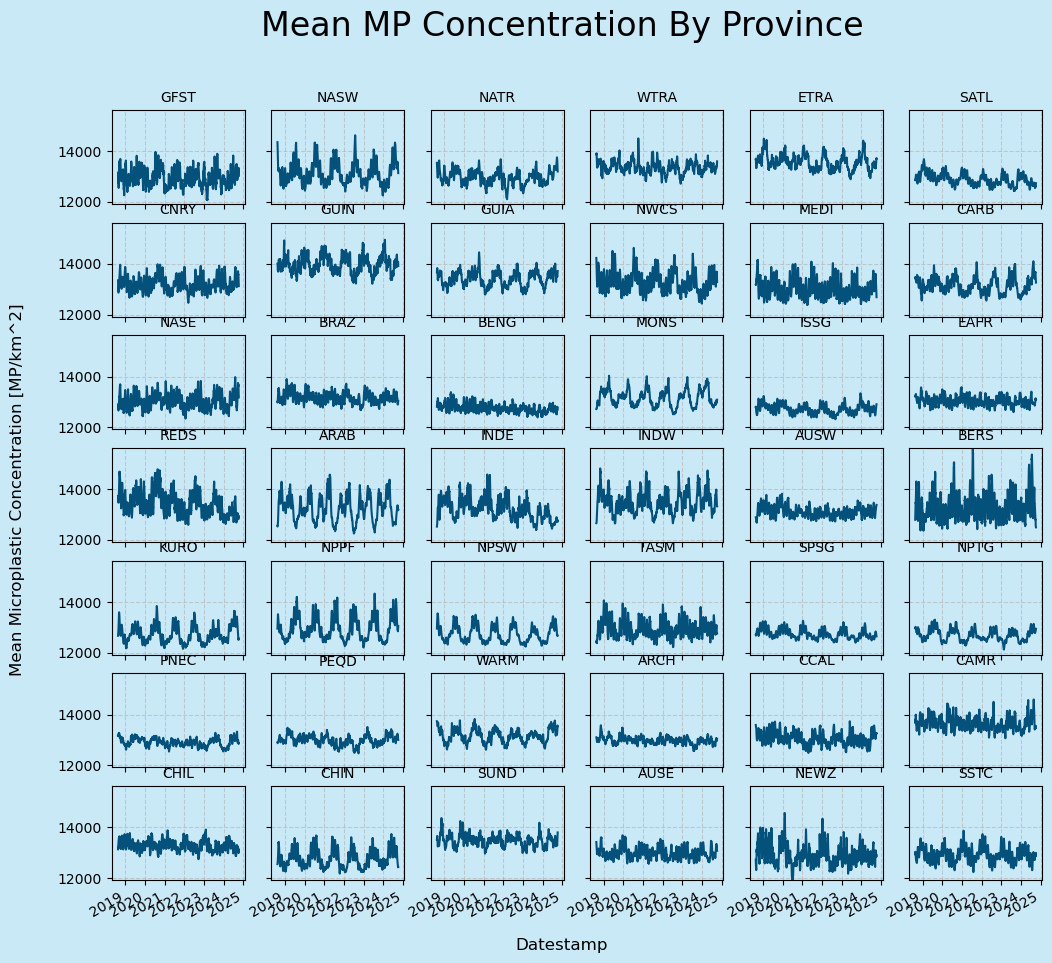

In [20]:
# Determine global y-axis limits across all 'mean' values in the data
y_min = filtered_df['mean'].apply(min).min()
y_max = filtered_df['mean'].apply(max).max()

# generate and format subplot figure
row, col = 7, 6
fig, axs = plt.subplots(row, col, figsize=(12, 10), sharex=True, sharey=True)  # Enable shared axes
fig.suptitle("Mean MP Concentration By Province", fontsize=24)
fig.patch.set_facecolor("#CAE9F7")

for i, (_, prov) in enumerate(filtered_df.iterrows()):
    ax = axs.flat[i]
    ax.plot(cygnss_data.time.values, prov['mean'], color='#04527C')
    ax.set_title(prov['ProvCode'], fontsize=10)
    ax.set_ylim(y_min, y_max)  # Set consistent y-axis limits
#     ax.yaxis.set_ticks(np.linspace(1.25*y_min, 0.75*y_max,3))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor("#CAE9F7")

# Rotate x-axis labels for the bottom row of subplots
for ax in axs[-1, :]:  # Access the last row of axes
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha("right")


# Add shared x and y labels for the entire figure
fig.text(0.5, 0.04, "Datestamp", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Mean Microplastic Concentration [MP/km^2]", va="center", rotation="vertical", fontsize=12)

plt.show()


### Load Libraries for Modeling

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from prophet import Prophet
from datetime import datetime, timedelta
from prophet.diagnostics import cross_validation, performance_metrics
import itertools


### Fit Model for Each Region

In [22]:
try:
    with open('model_dict2.pkl', 'rb') as handle:
        model_dict = pickle.load(handle)
except:
    model_dict = {}

    for _, prov in filtered_df.iterrows():
        # Create DataFrame in Prophet format
        prophet_df = pd.DataFrame({
                                    'ds': cygnss_data.time.values,
                                    'y':  prov['mean']
                                 })

        cutoffs = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01'])

        param_grid = {  
            'changepoint_prior_scale': [0.0001, 0.001, 0.01, 0.1],
            'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0],
        }

        # Generate all combinations of parameters
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        for params in all_params:
            m = Prophet(**params).fit(prophet_df)  # Fit model with given params
            df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])

        # get the best parameters with the lowest rmse
        best_params = all_params[np.argmin(rmses)]
        best_params

    #     # Find the best parameters
    #     tuning_results = pd.DataFrame(all_params)
    #     tuning_results['rmse'] = rmses
    #     print(tuning_results)

        # Initialize and fit the Prophet model
        model_dict[prov.ProvCode] = Prophet(
                                            yearly_seasonality=True,
                                            weekly_seasonality=True,
                                            daily_seasonality=False,
                                            **best_params
    #                                         changepoint_prior_scale=0.05,  # Flexibility of trend changes
    #                                         seasonality_prior_scale=10,    # Flexibility of seasonality
                                        )
        model_dict[prov.ProvCode].fit(prophet_df)

20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:25 - cmdstanpy - INFO - Chain [1] done processing
20:53:25 - cmdstanpy - INFO - Chain [1] start processing
20:53:25 - cmdstanpy - INFO - Chain [1] start processing
20:53:25 - cmdstanpy - INFO - Chain [1] start processing
20:53:25 - cmdstanpy - INFO - Chain [1] done processing
20:53:25 - cmdstanpy - INFO - Chain [1] done processing
20:53:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:53:25 - cmdstanpy - INFO - Chain [1] done processing
20:53:25 - cmdstanpy - INFO - Chain [1] start processing
20:53:26 - cmdstanpy - INFO - Chain [1] done processing
20:53:26 - cmdstanpy - INFO - Chain [1] start processing
20:53:26 - cmdstanpy - INFO - Chain [1] done processing
20:53:27 - cmdstanpy - INFO - Chain [1] start processing
20:53:27 - cmdstanpy - INFO - Chain [1] start processing
20:53:27 - cmdstanpy - INFO - Chain [1] done process

20:53:47 - cmdstanpy - INFO - Chain [1] done processing
20:53:47 - cmdstanpy - INFO - Chain [1] start processing
20:53:47 - cmdstanpy - INFO - Chain [1] done processing
20:53:48 - cmdstanpy - INFO - Chain [1] start processing
20:53:48 - cmdstanpy - INFO - Chain [1] done processing
20:53:48 - cmdstanpy - INFO - Chain [1] start processing
20:53:48 - cmdstanpy - INFO - Chain [1] start processing
20:53:48 - cmdstanpy - INFO - Chain [1] done processing
20:53:48 - cmdstanpy - INFO - Chain [1] done processing
20:53:48 - cmdstanpy - INFO - Chain [1] start processing
20:53:48 - cmdstanpy - INFO - Chain [1] done processing
20:53:49 - cmdstanpy - INFO - Chain [1] start processing
20:53:49 - cmdstanpy - INFO - Chain [1] start processing
20:53:49 - cmdstanpy - INFO - Chain [1] done processing
20:53:49 - cmdstanpy - INFO - Chain [1] start processing
20:53:49 - cmdstanpy - INFO - Chain [1] done processing
20:53:49 - cmdstanpy - INFO - Chain [1] done processing
20:53:49 - cmdstanpy - INFO - Chain [1] 

20:54:06 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:09 - cmdstanpy - INFO - Chain [1] 

20:54:27 - cmdstanpy - INFO - Chain [1] done processing
20:54:28 - cmdstanpy - INFO - Chain [1] start processing
20:54:28 - cmdstanpy - INFO - Chain [1] start processing
20:54:28 - cmdstanpy - INFO - Chain [1] done processing
20:54:28 - cmdstanpy - INFO - Chain [1] done processing
20:54:28 - cmdstanpy - INFO - Chain [1] start processing
20:54:28 - cmdstanpy - INFO - Chain [1] done processing
20:54:28 - cmdstanpy - INFO - Chain [1] start processing
20:54:28 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:30 - cmdstanpy - INFO - Chain [1] 

20:54:53 - cmdstanpy - INFO - Chain [1] done processing
20:54:53 - cmdstanpy - INFO - Chain [1] start processing
20:54:53 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:54 - cmdstanpy - INFO - Chain [1] start processing
20:54:54 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] start processing
20:54:55 - cmdstanpy - INFO - Chain [1] done processing
20:54:55 - cmdstanpy - INFO - Chain [1] 

20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] done processing
20:55:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:55:15 - cmdstanpy - INFO - Chain [1] done processing
20:55:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] done processing
20:55:16 -

20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:36 - cmdstanpy - INFO - Chain [1] done processing
20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:36 - cmdstanpy - INFO - Chain [1] done processing
20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:36 - cmdstanpy - INFO - Chain [1] done processing
20:55:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing
20:55:37 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing
20:55:38 - cmdstanpy - INFO - Chain [1] start processing
20:55:38 - cmdstanpy - INFO - Chain [1] start processing
20:55:38 - cmdstanpy - INFO - Chain [1] done processing
20:55:38 - cmdstanpy - INFO - Chain [1] done processing
20:55:38 - cmdstanpy - INFO - Chain [1] start process

20:55:58 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:56:01 -

20:56:20 - cmdstanpy - INFO - Chain [1] done processing
20:56:20 - cmdstanpy - INFO - Chain [1] start processing
20:56:20 - cmdstanpy - INFO - Chain [1] done processing
20:56:21 - cmdstanpy - INFO - Chain [1] start processing
20:56:21 - cmdstanpy - INFO - Chain [1] start processing
20:56:21 - cmdstanpy - INFO - Chain [1] done processing
20:56:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:56:21 - cmdstanpy - INFO - Chain [1] start processing
20:56:21 - cmdstanpy - INFO - Chain [1] done processing
20:56:21 - cmdstanpy - INFO - Chain [1] start processing
20:56:21 - cmdstanpy - INFO - Chain [1] done processing
20:56:26 - cmdstanpy - INFO - Chain [1] done processing
20:56:26 - cmdstanpy - INFO - Chain [1] start processing
20:56:26 - cmdstanpy - INFO - Chain [1] done processing
20:56:27 - cmdstanpy - INFO - Chain [1] start processing
20:56:27 - cmdstanpy - INFO - Chain [1] start process

20:56:50 - cmdstanpy - INFO - Chain [1] done processing
20:56:50 - cmdstanpy - INFO - Chain [1] done processing
20:56:50 - cmdstanpy - INFO - Chain [1] start processing
20:56:50 - cmdstanpy - INFO - Chain [1] done processing
20:56:51 - cmdstanpy - INFO - Chain [1] start processing
20:56:51 - cmdstanpy - INFO - Chain [1] done processing
20:56:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:56:51 - cmdstanpy - INFO - Chain [1] start processing
20:56:51 - cmdstanpy - INFO - Chain [1] start processing
20:56:51 - cmdstanpy - INFO - Chain [1] done processing
20:56:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:56:51 - cmdstanpy - INFO - Chain [1] start processing
20:56:51 - cmdstanpy - INFO - Chain [1] start processing
20:56:51 - cmdstanpy - INFO - Chain [1] done processing
20:56:52 -

20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:17 - cmdstanpy - INFO - Chain [1] done processing
20:57:17 - cmdstanpy - INFO - Chain [1] start processing
20:57:17 - cmdstanpy - INFO - Chain [1] done processi

20:57:34 - cmdstanpy - INFO - Chain [1] start processing
20:57:34 - cmdstanpy - INFO - Chain [1] done processing
20:57:34 - cmdstanpy - INFO - Chain [1] start processing
20:57:34 - cmdstanpy - INFO - Chain [1] done processing
20:57:35 - cmdstanpy - INFO - Chain [1] start processing
20:57:35 - cmdstanpy - INFO - Chain [1] done processing
20:57:35 - cmdstanpy - INFO - Chain [1] start processing
20:57:35 - cmdstanpy - INFO - Chain [1] start processing
20:57:35 - cmdstanpy - INFO - Chain [1] done processing
20:57:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:57:35 - cmdstanpy - INFO - Chain [1] start processing
20:57:35 - cmdstanpy - INFO - Chain [1] done processing
20:57:36 - cmdstanpy - INFO - Chain [1] done processing
20:57:36 - cmdstanpy - INFO - Chain [1] start processing
20:57:36 - cmdstanpy - INFO - Chain [1] done processing
20:57:37 - cmdstanpy - INFO - Chain [1] start process

20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] done processing
20:58:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] done processing
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] done processing
20:58:03 - cmdstanpy - INFO - Chain [1] done processin

20:58:20 - cmdstanpy - INFO - Chain [1] done processing
20:58:20 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:22 - cmdstanpy - INFO - Chain [1] start processing
20:58:22 - cmdstanpy - INFO - Chain [1] start processing
20:58:22 - cmdstanpy - INFO - Chain [1] done processing
20:58:22 - cmdstanpy - INFO - Chain [1] start processing
20:58:22 - cmdstanpy - INFO - Chain [1] done processing
20:58:22 - cmdstanpy - INFO - Chain [1] done processing
20:58:22 - cmdstanpy - INFO - Chain [1] 

20:58:40 - cmdstanpy - INFO - Chain [1] done processing
20:58:40 - cmdstanpy - INFO - Chain [1] start processing
20:58:40 - cmdstanpy - INFO - Chain [1] done processing
20:58:41 - cmdstanpy - INFO - Chain [1] start processing
20:58:41 - cmdstanpy - INFO - Chain [1] start processing
20:58:41 - cmdstanpy - INFO - Chain [1] done processing
20:58:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
20:58:41 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
20:58:41 - cmdstanpy - INFO - Chain [1] start processing
20:58:41 - cmdstanpy - INFO - Chain [1] start processing
20:58:41 - cmdstanpy - INFO - Chain [1] done processing
20:58:41 - cmdstanpy - INFO - Chain [1] done processing
20:58:42 - cmdstanpy - INFO - Chain [1] start processing
20:58:42 - cmdstanpy - INFO - Chain [1] done processing
20:58:42 - cmdstanpy - INFO - Chain [1] start processing
20:58:42 - cmdstanpy - INFO - Chain [1] start process

20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:59:00 - cmdstanpy - INFO - Chain [1] start processing
20:59:00 - cmdstanpy - INFO - Chain [1] start processing
20:59:00 - cmdstanpy - INFO - Chain [1] start processing
20:59:00 - cmdstanpy - INFO - Chain [1] done processing
20:59:00 - cmdstanpy - INFO - Chain [1] done processing
20:59:00 - cmdstanpy - INFO - Chain [1] done processing
20:59:00 - cmdstanpy - INFO - Chain [1] start processing
20:59:00 - cmdstanpy - INFO - Chain [1] done processing
20:59:01 - cmdstanpy - INFO - Chain [1] start processing
20:59:01 - cmdstanpy - INFO - Chain [1] start processing
20:59:01 - cmdstanpy - INFO - Chain [1] done processing
20:59:01 - cmdstanpy - INFO - Chain [1] done processing
20:59:01 - cmdstanpy - INFO - Chain [1] start processing
20:59:01 - cmdstanpy - INFO - Chain [1] done processing
20:59:01 - cmdstanpy - INFO - Chain [1] start processing
20:59:01 - cmdstanpy - INFO - Chain [1] done processing
20:59:02 - cmdstanpy - INFO - Chain [1] 

20:59:20 - cmdstanpy - INFO - Chain [1] done processing
20:59:20 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing
20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing
20:59:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:59:21 - cmdstanpy - INFO - Chain [1] start processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing
20:59:21 - cmdstanpy - INFO - Chain [1] done processing
20:59:22 - cmdstanpy - INFO - Chain [1] done processing
20:59:22 - cmdstanpy - INFO - Chain [1] start processing
20:59:22 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] start process

20:59:50 - cmdstanpy - INFO - Chain [1] done processing
20:59:51 - cmdstanpy - INFO - Chain [1] done processing
20:59:51 - cmdstanpy - INFO - Chain [1] start processing
20:59:51 - cmdstanpy - INFO - Chain [1] done processing
20:59:51 - cmdstanpy - INFO - Chain [1] start processing
20:59:51 - cmdstanpy - INFO - Chain [1] start processing
20:59:51 - cmdstanpy - INFO - Chain [1] done processing
20:59:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:59:51 - cmdstanpy - INFO - Chain [1] done processing
20:59:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
20:59:51 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
20:59:51 - cmdstanpy - INFO - Chain [1] start processing
20:59:51 - cmdstanpy - INFO - Chain [1] start processing
20:59:52 - cmdstanpy - INFO - Chain [1] done processing
20:59:52 -

21:00:14 - cmdstanpy - INFO - Chain [1] done processing
21:00:19 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:21 -

21:00:43 - cmdstanpy - INFO - Chain [1] done processing
21:00:43 - cmdstanpy - INFO - Chain [1] start processing
21:00:43 - cmdstanpy - INFO - Chain [1] done processing
21:00:43 - cmdstanpy - INFO - Chain [1] start processing
21:00:43 - cmdstanpy - INFO - Chain [1] done processing
21:00:44 - cmdstanpy - INFO - Chain [1] start processing
21:00:44 - cmdstanpy - INFO - Chain [1] done processing
21:00:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:00:44 - cmdstanpy - INFO - Chain [1] start processing
21:00:44 - cmdstanpy - INFO - Chain [1] start processing
21:00:44 - cmdstanpy - INFO - Chain [1] start processing
21:00:44 - cmdstanpy - INFO - Chain [1] done processing
21:00:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:00:44 - cmdstanpy - INFO - Chain [1] start processing
21:00:44 

21:01:04 - cmdstanpy - INFO - Chain [1] done processing
21:01:05 - cmdstanpy - INFO - Chain [1] start processing
21:01:05 - cmdstanpy - INFO - Chain [1] start processing
21:01:05 - cmdstanpy - INFO - Chain [1] start processing
21:01:05 - cmdstanpy - INFO - Chain [1] done processing
21:01:05 - cmdstanpy - INFO - Chain [1] done processing
21:01:05 - cmdstanpy - INFO - Chain [1] done processing
21:01:05 - cmdstanpy - INFO - Chain [1] start processing
21:01:05 - cmdstanpy - INFO - Chain [1] done processing
21:01:06 - cmdstanpy - INFO - Chain [1] start processing
21:01:06 - cmdstanpy - INFO - Chain [1] start processing
21:01:06 - cmdstanpy - INFO - Chain [1] start processing
21:01:06 - cmdstanpy - INFO - Chain [1] done processing
21:01:06 - cmdstanpy - INFO - Chain [1] done processing
21:01:06 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:08 - cmdstanpy - INFO - Chain [1] 

21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:29 - cmdstanpy - INFO - Chain [1] done processing
21:01:29 - cmdstanpy - INFO - Chain [1] start processing
21:01:29 - cmdstanpy - INFO - Chain [1] done processing
21:01:30 - cmdstanpy - INFO - Chain [1] start processing
21:01:30 - cmdstanpy - INFO - Chain [1] start processing
21:01:30 - cmdstanpy - INFO - Chain [1] start processing
21:01:30 - cmdstanpy - INFO - Chain [1] done processing
21:01:30 - cmdstanpy - INFO - Chain [1] done processing
21:01:30 - cmdstanpy - INFO - Chain [1] 

21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing
21:01:52 - cmdstanpy - INFO - Chain [1] start processing
21:01:52 - cmdstanpy - INFO - Chain [1] done processing
21:01:53 - cmdstanpy - INFO - Chain [1] start processing
21:01:53 - cmdstanpy - INFO - Chain [1]

21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:12 - cmdstanpy - INFO - Chain [1] start processing
21:02:12 - cmdstanpy - INFO - Chain [1] done processing
21:02:13 - cmdstanpy - INFO - Chain [1] start processing
21:02:13 - cmdstanpy - INFO - Chain [1] start processing
21:02:13 - cmdstanpy - INFO - Chain [1] start processing
21:02:13 - cmdstanpy - INFO - Chain [1] done processing
21:02:13 - cmdstanpy - INFO - Chain [1] done processing
21:02:13 - cmdstanpy - INFO - Chain [1] done processing
21:02:13 - cmdstanpy - INFO - Chain [1] start processing
21:02:14 - cmdstanpy - INFO - Chain [1] done processing
21:02:14 - cmdstanpy - INFO - Chain [1] 

21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:44 - cmdstanpy - INFO - Chain [1] start processing
21:02:44 - cmdstanpy - INFO - Chain [1] start processing
21:02:44 - cmdstanpy - INFO - Chain [1] done processing
21:02:44 - cmdstanpy - INFO - Chain [1] done processing
21:02:44 - cmdstanpy - INFO - Chain [1] start processing
21:02:44 - cmdstanpy - INFO - Chain [1] done processing
21:02:44 - cmdstanpy - INFO - Chain [1] start processing
21:02:44 - cmdstanpy - INFO - Chain [1] done processing
21:02:45 - cmdstanpy - INFO - Chain [1] 

21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:03 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1]

21:03:19 - cmdstanpy - INFO - Chain [1] done processing
21:03:19 - cmdstanpy - INFO - Chain [1] start processing
21:03:19 - cmdstanpy - INFO - Chain [1] done processing
21:03:20 - cmdstanpy - INFO - Chain [1] start processing
21:03:20 - cmdstanpy - INFO - Chain [1] start processing
21:03:20 - cmdstanpy - INFO - Chain [1] start processing
21:03:20 - cmdstanpy - INFO - Chain [1] done processing
21:03:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:20 - cmdstanpy - INFO - Chain [1] done processing
21:03:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:20 - cmdstanpy - INFO - Chain [1] start processing
21:03:20 - cmdstanpy - INFO - Chain [1] done processing
21:03:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

21:03:39 - cmdstanpy - INFO - Chain [1] done processing
21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:39 - cmdstanpy - INFO - Chain [1] done processing
21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:39 - cmdstanpy - INFO - Chain [1] done processing
21:03:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:41 - cmdstanpy - INFO - Chain [1] start processing
21:03:41 - cmdstanpy - INFO - Chain [1] start process

21:04:16 - cmdstanpy - INFO - Chain [1] done processing
21:04:16 - cmdstanpy - INFO - Chain [1] start processing
21:04:16 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:18 - cmdstanpy - INFO - Chain [1] done processing
21:04:19 - cmdstanpy - INFO - Chain [1] start processing
21:04:19 - cmdstanpy - INFO - Chain [1] done processing
21:04:19 - cmdstanpy - INFO - Chain [1] start processing
21:04:19 - cmdstanpy - INFO - Chain [1] start process

21:04:37 - cmdstanpy - INFO - Chain [1] done processing
21:04:38 - cmdstanpy - INFO - Chain [1] start processing
21:04:38 - cmdstanpy - INFO - Chain [1] done processing
21:04:38 - cmdstanpy - INFO - Chain [1] start processing
21:04:38 - cmdstanpy - INFO - Chain [1] start processing
21:04:38 - cmdstanpy - INFO - Chain [1] done processing
21:04:38 - cmdstanpy - INFO - Chain [1] done processing
21:04:38 - cmdstanpy - INFO - Chain [1] start processing
21:04:38 - cmdstanpy - INFO - Chain [1] done processing
21:04:39 - cmdstanpy - INFO - Chain [1] start processing
21:04:39 - cmdstanpy - INFO - Chain [1] done processing
21:04:39 - cmdstanpy - INFO - Chain [1] start processing
21:04:39 - cmdstanpy - INFO - Chain [1] start processing
21:04:39 - cmdstanpy - INFO - Chain [1] done processing
21:04:39 - cmdstanpy - INFO - Chain [1] done processing
21:04:39 - cmdstanpy - INFO - Chain [1] start processing
21:04:39 - cmdstanpy - INFO - Chain [1] done processing
21:04:40 - cmdstanpy - INFO - Chain [1] 

21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:04:59 - cmdstanpy - INFO - Chain [1] start processing
21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start process

21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] done processing
21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] done processing
21:05:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] done processing
21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] done processing
21:05:22 - cmdstanpy - INFO - Chain [1] done processing
21:05:22 - cmdstanpy - INFO - Chain [1] start processing
21:05:22 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] start process

21:05:43 - cmdstanpy - INFO - Chain [1] done processing
21:05:43 - cmdstanpy - INFO - Chain [1] start processing
21:05:43 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:44 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:44 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:44 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - INFO - Chain [1] done processing
21:05:44 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing
21:05:45 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processi

21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:05 - cmdstanpy - INFO - Chain [1] done processing
21:06:05 - cmdstanpy - INFO - Chain [1] done processing
21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:05 - cmdstanpy - INFO - Chain [1] done processing
21:06:05 - cmdstanpy - INFO - Chain [1] start processing
21:06:05 - cmdstanpy - INFO - Chain [1] done processing
21:06:06 - cmdstanpy - INFO - Chain [1] start processing
21:06:06 - cmdstanpy - INFO - Chain [1] start processing
21:06:06 - cmdstanpy - INFO - Chain [1] done processing
21:06:06 - cmdstanpy - INFO - Chain [1] start processing
21:06:06 - cmdstanpy - INFO - Chain [1] done processing
21:06:06 - cmdstanpy - INFO - Chain [1] done processing
21:06:06 - cmdstanpy - INFO - Chain [1] start processing
21:06:06 - cmdstanpy - INFO - Chain [1] done processing
21:06:07 - cmdstanpy - INFO - Chain [1] start processing
21:06:07 - cmdstanpy - INFO - Chain [1]

21:06:26 - cmdstanpy - INFO - Chain [1] done processing
21:06:26 - cmdstanpy - INFO - Chain [1] start processing
21:06:26 - cmdstanpy - INFO - Chain [1] start processing
21:06:26 - cmdstanpy - INFO - Chain [1] done processing
21:06:26 - cmdstanpy - INFO - Chain [1] start processing
21:06:26 - cmdstanpy - INFO - Chain [1] done processing
21:06:26 - cmdstanpy - INFO - Chain [1] done processing
21:06:26 - cmdstanpy - INFO - Chain [1] start processing
21:06:26 - cmdstanpy - INFO - Chain [1] done processing
21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing
21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing
21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] 

21:06:46 - cmdstanpy - INFO - Chain [1] done processing
21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing
21:06:47 - cmdstanpy - INFO - Chain [1] start processing
21:06:47 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:49 - cmdstanpy - INFO - Chain [1] 

21:07:06 - cmdstanpy - INFO - Chain [1] done processing
21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:07 - cmdstanpy - INFO - Chain [1] done processing
21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:07 - cmdstanpy - INFO - Chain [1] done processing
21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:07 - cmdstanpy - INFO - Chain [1] done processing
21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:07 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing
21:07:10 - cmdstanpy - INFO - Chain [1] 

21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:31 - cmdstanpy - INFO - Chain [1] 

21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing
21:08:06 - cmdstanpy - INFO - Chain [1] done processing
21:08:06 - cmdstanpy - INFO - Chain [1] start processing
21:08:06 - cmdstanpy - INFO - Chain [1]

21:08:27 - cmdstanpy - INFO - Chain [1] done processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing
21:08:28 - cmdstanpy - INFO - Chain [1] start processing
21:08:28 - cmdstanpy - INFO - Chain [1] done processing
21:08:29 - cmdstanpy - INFO - Chain [1] start processing
21:08:29 - cmdstanpy - INFO - Chain [1] start processing
21:08:29 - cmdstanpy - INFO - Chain [1] start processing
21:08:29 - cmdstanpy - INFO - Chain [1] done processing
21:08:29 - cmdstanpy - INFO - Chain [1] done processing
21:08:29 - cmdstanpy - INFO - Chain [1] done processing
21:08:29 - cmdstanpy - INFO - Chain [1] start processing
21:08:29 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] 

21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:53 - cmdstanpy - INFO - Chain [1] start processing
21:08:53 - cmdstanpy - INFO - Chain [1] start processing
21:08:53 - cmdstanpy - INFO - Chain [1] done processing
21:08:53 - cmdstanpy - INFO - Chain [1] done processing
21:08:53 - cmdstanpy - INFO - Chain [1] start processing
21:08:53 - cmdstanpy - INFO - Chain [1] done processing
21:08:53 - cmdstanpy - INFO - Chain [1] start processing
21:08:53 - cmdstanpy - INFO - Chain [1] done processing
21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:54 - cmdstanpy - INFO - Chain [1] start processing
21:08:54 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] 

21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:19 - cmdstanpy - INFO - Chain [1] start processing
21:09:19 - cmdstanpy - INFO - Chain [1] done processing
21:09:19 - cmdstanpy - INFO - Chain [1] start processing
21:09:19 - cmdstanpy - INFO - Chain [1] done processing
21:09:19 - cmdstanpy - INFO - Chain [1] 

21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:39 - cmdstanpy - INFO - Chain [1] start processing
21:09:39 - cmdstanpy - INFO - Chain [1] done processing
21:09:39 - cmdstanpy - INFO - Chain [1] 

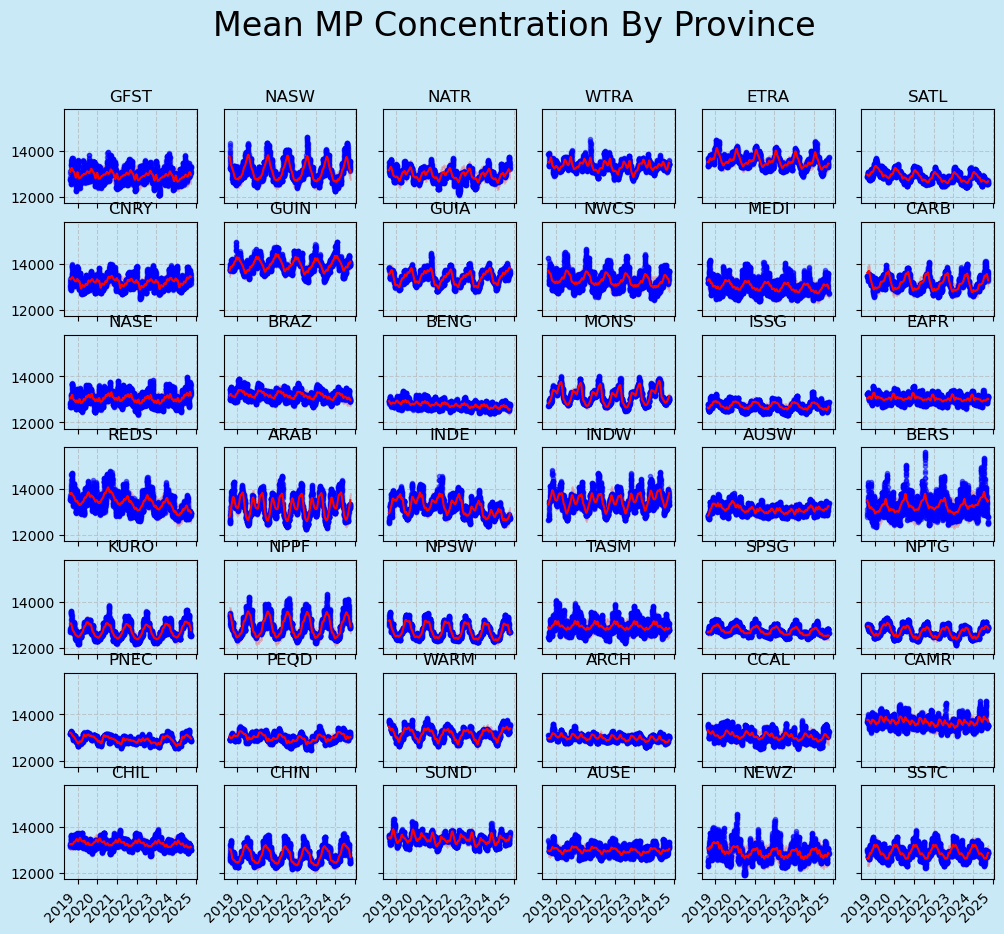

In [25]:
# latest_date = prophet_df['ds'].max()
# one_year_ago = latest_date - pd.DateOffset(years=1)

# # Create a dataframe for the backcast period
# historical_dates = pd.date_range(
#     start=one_year_ago,
#     end=latest_date,
#     freq='D'
# )
# historical_df = pd.DataFrame({'ds': historical_dates})

# generate and format subplot figure
row, col = 7, 6
fig, axs = plt.subplots(row, col, figsize=(12, 10), sharex=True, sharey=True)  # Enable shared axes
fig.suptitle("Mean MP Concentration By Province", fontsize=24)
fig.patch.set_facecolor("#CAE9F7")

for i, (prov, model) in enumerate(model_dict.items()):
    
    prophet_df = pd.DataFrame({
                                    'ds': cygnss_data.time.values,
                                    'y':  filtered_df[filtered_df['ProvCode'] == prov]['mean'].values[0]
                                 })
    
    # Generate predictions
    backcast = model.predict(prophet_df)

    # Get actual values for comparison
#     actual_data = prophet_df[prophet_df['ds'] >= one_year_ago].copy()
    actual_data = prophet_df

    # Merge predictions with actual data
    comparison = pd.merge(
        backcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
        actual_data,
        on='ds',
        how='left'
    )

#     plt.figure(figsize=(15, 8))
    ax = axs.flat[i]
    ax.set_facecolor("#CAE9F7")
        
    # Plot actual values
    ax.plot(comparison['ds'], comparison['y'], 'b.', 
            label='Actual Values', alpha=0.5)

    # Plot predicted values
    ax.plot(comparison['ds'], comparison['yhat'], 'r-', 
            label='Prophet Backcast')

    # Plot confidence intervals
    ax.fill_between(
        comparison['ds'],
        comparison['yhat_lower'],
        comparison['yhat_upper'],
        color='r',
        alpha=0.2,
        label='Confidence Interval'
    )
    ax.set_title(prov)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor("#CAE9F7")
#     ax.title('Prophet Backcast vs Actual Values - Last Year')
#     plt.legend()
#     plt.grid(True)
#     ax.set_xticks(rot=45)
#     plt.tight_layout()
#     plt.show()

# Rotate x-axis labels for the bottom row of subplots
for ax in axs[-1, :]:  # Access the last row of axes
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")  # Align the labels to the right for better readability
